<img src="figures/logos.png" style="float: centre;" width="800"/>

# Volcano practical

## Written for the COMET InSAR Workshop 2021.

Welcome to this COMET practical on measuring volcanic deformation with InSAR.

This practical has been tested in the latest versions of Chrome and Firefox, but should work in most modern browsers.

### Interacting with this practical

To run a cell containing code, you can either press "Run" in the bar above, or press "Shift+Enter".

A "#" indicates a comment within the code. 

##################################### <br />
Blocks of code surrounded by multiple "#" (like this one) indicate variables that you can experiment changing the values to. While you can experiment with the full body of code further (and I encourage you to do so after the course), we are limited in our ability to help you debug any errors you may encounter. Changing just the values indicate should result in no major errors. <br />
#####################################

If you get a "dead kernel" error, either restart the kernel under "Kernel" on the top bar, or reopen the binder fresh. None of your changes here will affect the original binder, so feel free to reload it if anything breaks.

### Acknowledgements

Detailed guidance on the content was provided by Susanna Ebmeier. Advice on the computational requirements of the practical was provided by Richard Rigby. Thanks to everyone for their contributions.

Andrew Watson - 2021

In [100]:
# Import required modules. Run this before continuing.

# these are for performing the analysis
import numpy as np
import pyproj

# these packages are required for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is additional scientific colour maps, see "https://www.fabiocrameri.ch/colourmaps/"
from cmcrameri import cm

# this is our own library of functions, and can be found in the same directory as this practical
import volcano_lib as lib

import importlib
importlib.reload(lib)

<module 'volcano_lib' from '/nfs/a285/homes/eearw/demonstrating/volcano_practical/volcano_lib.py'>

## 0. Introduction

A Mogi model is a point-source model used to explain surface deformation above an expanding magma chamber.

<img src="figures/mogi.png" style="float: centre;" width="600"/>

*Figure 1: Schematic diagram of a Mogi source. From Lisowski (2007)*

We make the following assumptions:
- the source is in an isotropic elastic half space, which is defined by the Poisson's ratio $v$, and the Shear modulus $\mu$.
- the radius of the point source is lower than it depth (can't break the surface).
- the magma itself is incompressible.

We can express a mogi source as:

\begin{equation}
\begin{pmatrix} ux \\ uy \\ uz \end{pmatrix} = \alpha^3 \delta P \frac{(1-v)}{\mu} \begin{pmatrix} x / R^3 \\ y / R^3 \\ z / R^3 \end{pmatrix} \qquad \qquad (1)
\end{equation}

where $ux$, $uy$, and $uz$ are the displacements in the x, y, and z axes, respecitvely. \alpha is the radius of the source at depth, $d$, measured to the centre of the source. $\delta P$ is the pressure change in the source. $R$ is the distance between the centre of the source and a position on the ground surface at which the displacements are calculated.

By taking the following approximation:
\begin{equation}
\delta V \approx \frac{\delta P}{\mu} \pi \alpha^3
\end{equation}

where $\delta V$ is the change in volume of the source.

We can rewrite Equation 1 as:

\begin{equation}
\begin{pmatrix} ux \\ uy \\ uz \end{pmatrix} = \delta V \frac{(1-v)}{\pi} \begin{pmatrix} x / R^3 \\ y / R^3 \\ z / R^3 \end{pmatrix} \qquad \qquad (2)
\end{equation}

## 1. Synthetic Mogi Source

Let's start by generating a simple models for an inflating magma chamber - a mogi source.

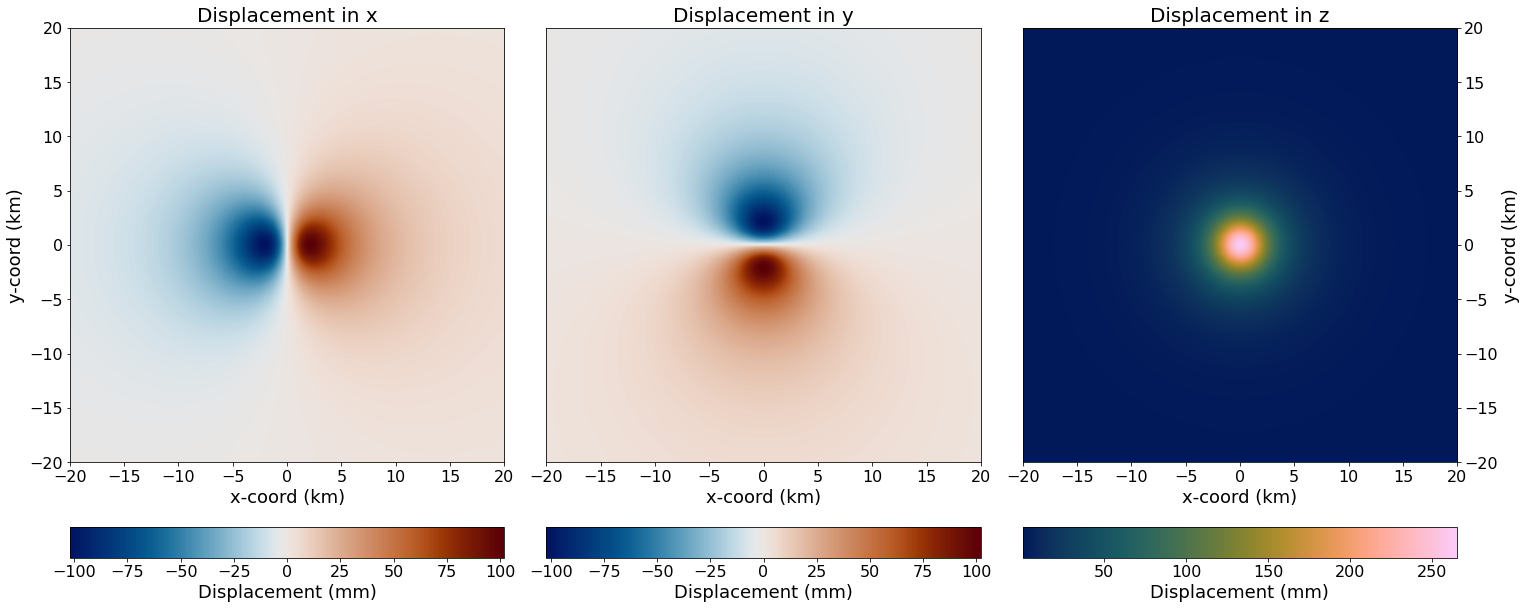

In [24]:
# setup model params
#####################################
source_depth = 3 # depth to point (km)
dV = 1e7 # change in volume (m^3)
nu = 0.25 # poisson's ratio for medium
#####################################

# setup coord limits in km
xmin, xmax, xint = -20, 20, 0.1
ymin, ymax, yint = -20, 20, 0.1

# make grids of x and y coordinates
x = np.arange(xmin, xmax+xint, xint)
y = np.arange(ymin, ymax+yint, yint)
xx, yy = np.meshgrid(x, y)

# generate displacements using Mogi source (note the unit conversions to metres)
ux, uy, uz = lib.mogi_source(xx*1000, yy*1000, d=source_depth*1000, dV=dV, nu=nu)

# plot the results
fig, axs = plt.subplots(1,3,figsize=(20,10))
fig.tight_layout()

# displacement in x
im = axs[0].imshow(ux*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('Displacement in x', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)

# displacement in y
im = axs[1].imshow(uy*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('Displacement in y', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].set_yticklabels([])
axs[1].set_yticks([])

# displacement in z
im = axs[2].imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[2].set_title('Displacement in z', fontsize=20)
axs[2].set_xlabel('x-coord (km)', fontsize=18)
axs[2].set_ylabel('y-coord (km)', fontsize=18)
axs[2].tick_params(labelsize=16)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")


Let's also plot these as a single 3D surface displacement map, using colour to show vertical motion, and vectors to show horizontal motion.

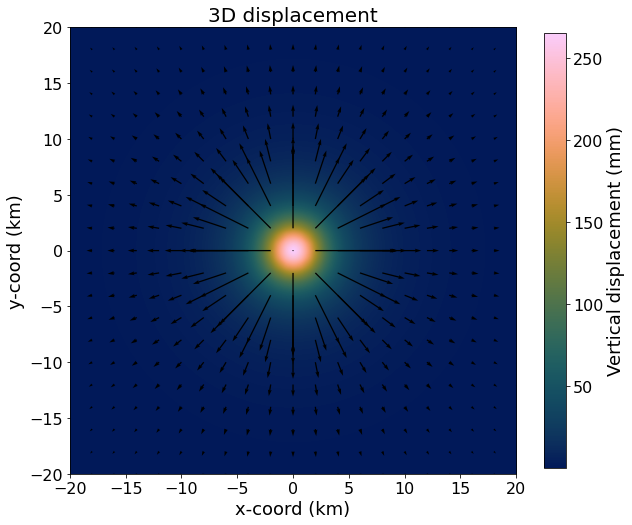

In [58]:
# downsample ux and uy so that we only draw arrows every 2 km
arr_spacing = 2 # km
xstep, ystep = round(arr_spacing/xint), round(arr_spacing/yint)
ux_ds = ux[0::ystep,0::xstep]
uy_ds = uy[0::ystep,0::xstep]
xx_ds = xx[0::ystep,0::xstep]
yy_ds = yy[0::ystep,0::xstep]

# plot figure
fig = plt.figure(figsize=(10,10))
im = plt.imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
plt.quiver(xx_ds, yy_ds, ux_ds, uy_ds)
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label(label='Vertical displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.title('3D displacement', fontsize=20)
plt.xlabel('x-coord (km)', fontsize=18)
plt.ylabel('y-coord (km)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

Let's also plot a profile through the $x$ and $u$ displacements at $y=0$.

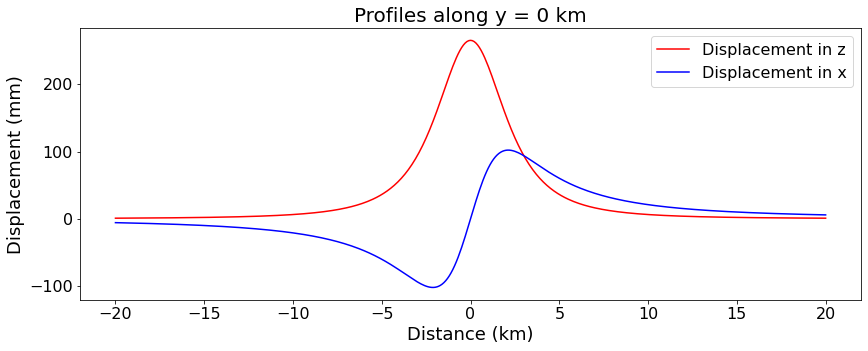

In [60]:
# get indexes of y=0
y0_ind = np.argmin(np.abs(y))

# profile across x=0 using simple indexing
prof_uz = uz[y0_ind,:]
prof_ux = ux[y0_ind,:]

# plot profiles
fig = plt.figure(figsize=(14,5))

plt.plot(x, prof_uz*1000, color='red', label='Displacement in z')
plt.plot(x, prof_ux*1000, color='blue', label='Displacement in x')
plt.legend(fontsize=16)
plt.title('Profiles along y = 0 km', fontsize=20)
plt.xlabel('Distance (km)', fontsize=18)
plt.ylabel('Displacement (mm)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

## 2. Impact of Satellite Line-of-Sight

The Sentinel-1 SAR Satellites use side-looking instruments. Also, measurements from InSAR are one-dimensional in the satellite's line-of-sight. These characteristics means that the displacements measured by InSAR are different to those generated by our Mogi model.

Let's run the model again but include the effect of LOS, starting with a single value for both the satellite heading and the incidence angle.

An incidence angle of 51&deg; is reasonable for both ascending and descending. In real data, this incidence angle varies across the image, but we'll stick to a fixed value for simplicity.

For heading, try -170&deg; for ascending, and -10&deg; for descending.

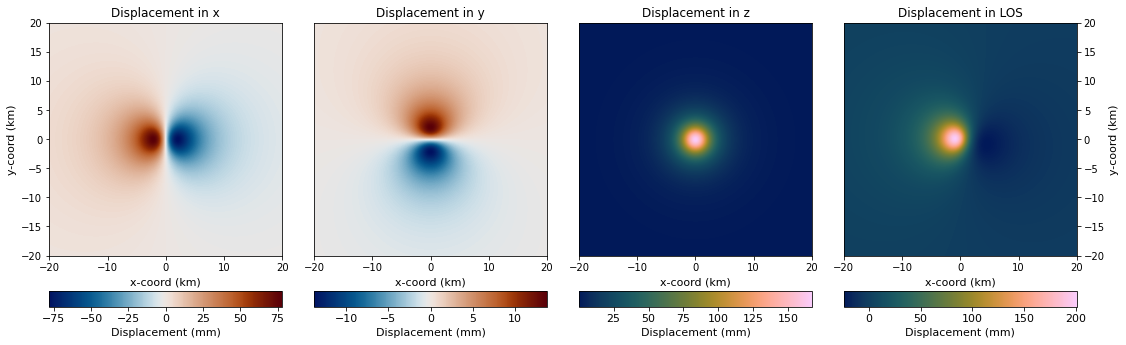

In [49]:
# params
#####################################
heading = -170 # degrees
incidence = 51 # degrees
#####################################

# create grids of these angles
heading_grid = np.ones(xx.shape) * heading
incidence_grid = np.ones(xx.shape) * incidence

# generate conversions for each components to LOS
x2los = np.cos(np.deg2rad(heading_grid)) * np.sin(np.deg2rad(incidence_grid))
y2los = np.sin(np.deg2rad(heading_grid)) * np.sin(np.deg2rad(incidence_grid))
z2los = np.cos(np.deg2rad(incidence_grid))

# apply projection
ux_los = ux * x2los
uy_los = uy * y2los
uz_los = uz * z2los

# calculate total displacement in los 
ulos = ux_los + uy_los + uz_los

# plot our new displacements
fig, axs = plt.subplots(1,4,figsize=(15,10))
fig.tight_layout(w_pad=0.1)

# displacement in x
im = axs[0].imshow(ux_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[0].set_title('Displacement in x')
axs[0].set_xlabel('x-coord (km)', fontsize=11)
axs[0].set_ylabel('y-coord (km)', fontsize=11)

# displacement in y
im = axs[1].imshow(uy_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[1].set_title('Displacement in y')
axs[1].set_xlabel('x-coord (km)', fontsize=11)
axs[1].set_yticklabels([])
axs[1].set_yticks([])

# displacement in z
im = axs[2].imshow(uz_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[2].set_title('Displacement in z')
axs[2].set_xlabel('x-coord (km)', fontsize=11)
axs[2].set_yticklabels([])
axs[2].set_yticks([])

# displacement in LOS
im = axs[3].imshow(ulos*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[3].set_title('Displacement in LOS')
axs[3].set_xlabel('x-coord (km)', fontsize=11)
axs[3].set_ylabel('y-coord (km)', fontsize=11)
axs[3].yaxis.tick_right()
axs[3].yaxis.set_label_position("right")

plt.show()

Let's compare our original 3D displacement figure with a wrapped version of our LOS displacements, which should make the change in the shape of the signal more apparent.

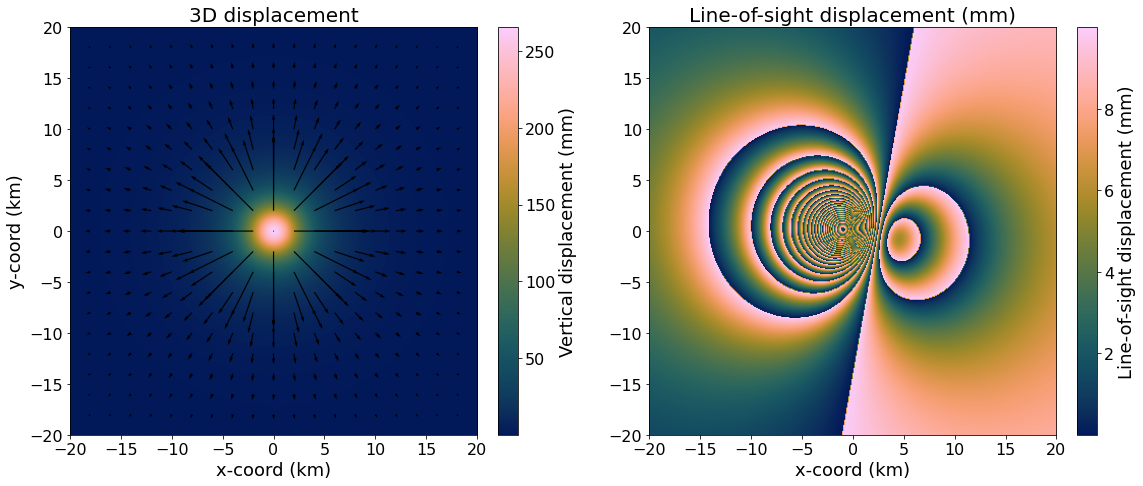

In [66]:
# plot
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout(w_pad=10)

# 3D displacements
im = axs[0].imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
axs[0].quiver(xx_ds, yy_ds, ux_ds, uy_ds)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Vertical displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('3D displacement', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)

# wrapped LOS
im = axs[1].imshow(np.remainder(ulos*1000, 10), extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('Wrapped line-of-sight displacement (mm)', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)

plt.show()

Let's again profile the displacements and compare the new LOS displacements to the original x and z displacements.

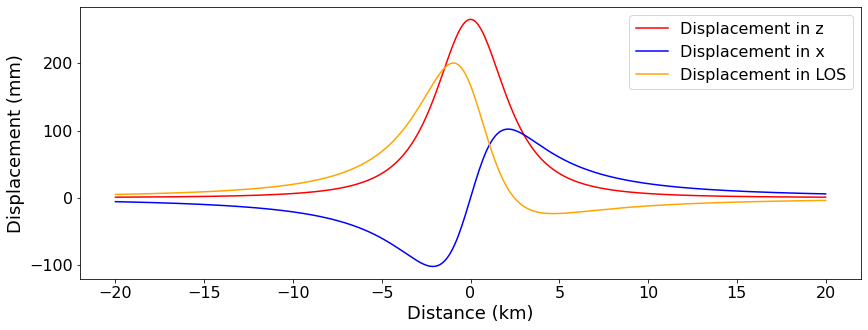

In [67]:
# profile los across y=0
prof_los = ulos[y0_ind,:]

# plot profiles
fig = plt.figure(figsize=(14,5))

plt.plot(x, prof_uz*1000, color='red', label='Displacement in z')
plt.plot(x, prof_ux*1000, color='blue', label='Displacement in x')
plt.plot(x, prof_los*1000, color='orange', label='Displacement in LOS')
plt.legend(fontsize=16)
plt.xlabel('Distance (km)', fontsize=18)
plt.ylabel('Displacement (mm)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

## 3. Topographic corrections

Our Mogi source currently assumes that the surface elevation is entirely flat.
In the real world, topography above the source will varying the depth to the source on a point-by-point basis, changing the overall signal.
Let's now add the effects of topography to our Mogi source.

In [9]:
# apply effect of topography to LOS displacements

# apply topographic correction

# plot the original model, the topography-adjusted, and the topography-corrected displacements

## 4. Real world example - Domuyo

We'll now apply our Mogi model to a real world example.
We'll be looking at Domuyo volcano in Argentina, which showed relatively consistent uplift between 2015 and 2020. Since the end of 2020, the volcano has begun to subside again. We'll model just the 2015-2020 period using our Mogi source.

The time series for Domuyo can be found on the COMET Volcano Portal at:
https://comet.nerc.ac.uk/comet-volcano-portal/volcano-index/South%20America/Argentina/Domuyo/S1_analysis

<img src="figures/Domuyo_from_portal.png" style="float: centre;" width="1000"/>

*Figure 2: Total displacement (left) and the displacement time series (right) from frame 018A_12668_131313 for Domuyo volcano, taken from the COMET Volcano Portal.*

Background information on the deformation at Domuyo can be found at:
https://www.nature.com/articles/s41598-020-67982-8

The volcano portal allows us to download a csv showing the cumulative displacement, coherence, and elevation at any time step for every point in the grid. I've provided two of these csv files, which we will load in and regrid.

The columns of these csv files are:
**latitude, longitude, displacement (mm), coherence, elevation (m)**

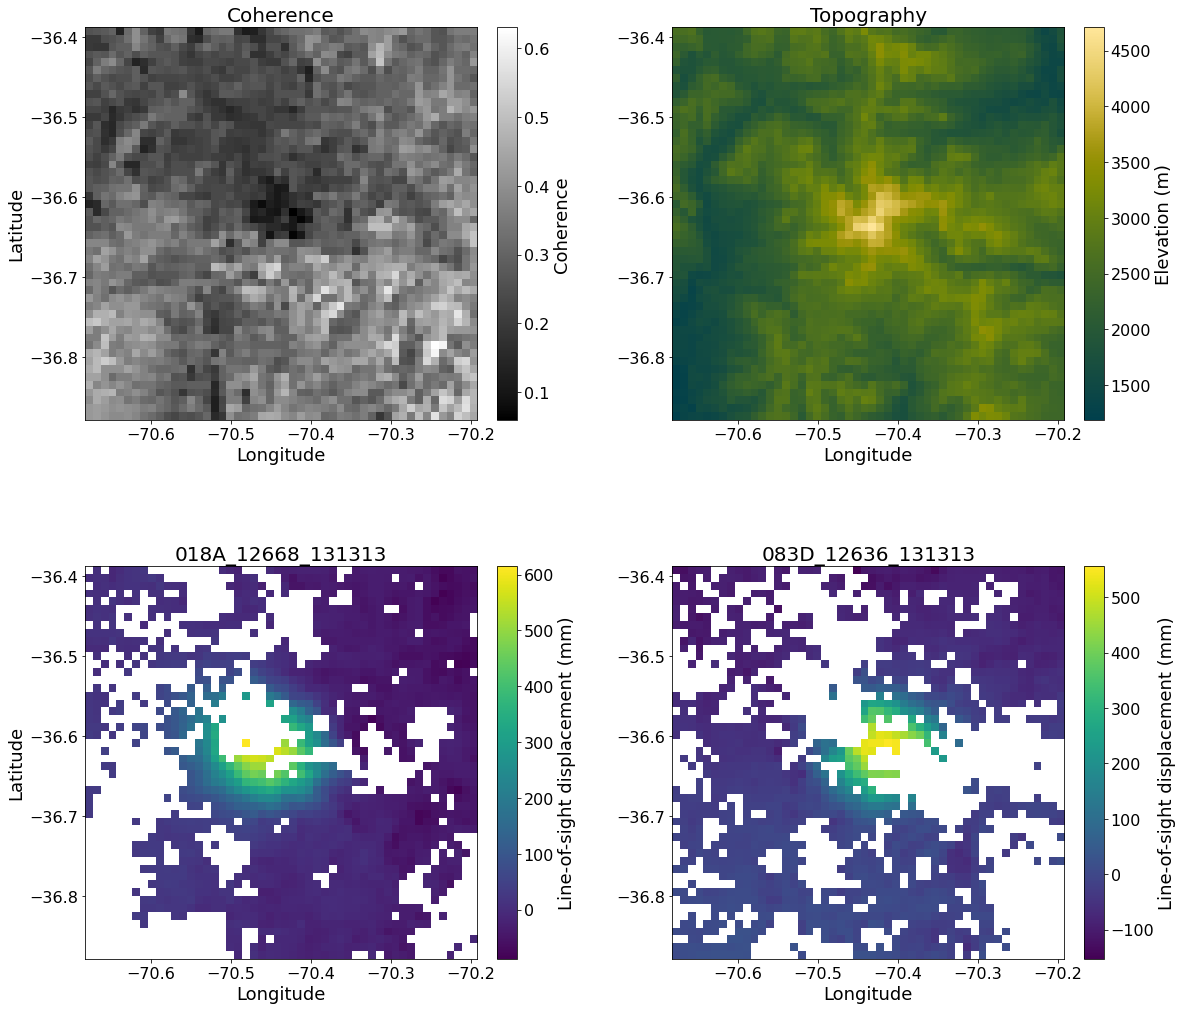

In [86]:
# use numpy to open the two csv files
input_asc = np.loadtxt('data/domuyo_018A_12668_131313_disp_raw.csv', delimiter=',', skiprows=1)
input_desc = np.loadtxt('data/domuyo_083D_12636_131313_disp_raw.csv', delimiter=',', skiprows=1)

# We can see that every grid position is included, with nan's used for padding,
# meaning we can simply reshape the columns into grids.

# get lat and lon coords by pulling the unique values from those columns
# these data are on the same grid, so we can use the ascending coords for both
lat = np.unique(input_asc[:,0])
lon = np.unique(input_asc[:,1])

# get axes limits
lat_min, lat_max = np.min(lat), np.max(lat)
lon_min, lon_max = np.min(lon), np.max(lon)

# reshape other columns into grids based on size on lat and lon
disp_asc = np.flipud(np.reshape(input_asc[:,2], (len(lat), len(lon))))
disp_desc = np.flipud(np.reshape(input_desc[:,2], (len(lat), len(lon))))

# same for coherence
coh_asc = np.flipud(np.reshape(input_asc[:,3], (len(lat), len(lon))))
coh_desc = np.flipud(np.reshape(input_desc[:,3], (len(lat), len(lon))))

# and same for elevation
elev_asc = np.flipud(np.reshape(input_asc[:,4], (len(lat), len(lon))))
elev_desc = np.flipud(np.reshape(input_desc[:,4], (len(lat), len(lon))))

# plot displacements, coherence, and elevation
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(w_pad=10, h_pad=2)

# coherence (we'll just show the ascending, almost the same for both)
im = axs[0,0].imshow(coh_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.grayC.reversed())
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Coherence', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,0].set_title('Coherence', fontsize=20)
axs[0,0].set_xlabel('Longitude', fontsize=18)
axs[0,0].set_ylabel('Latitude', fontsize=18)
axs[0,0].tick_params(labelsize=16)

# topography (we'll just show the ascending, identical for both)
im = axs[0,1].imshow(elev_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.bamako)
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Elevation (m)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,1].set_title('Topography', fontsize=20)
axs[0,1].set_xlabel('Longitude', fontsize=18)
axs[0,1].tick_params(labelsize=16)

# ascending displacement
im = axs[1,0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,0].set_title('018A_12668_131313', fontsize=20)
axs[1,0].set_xlabel('Longitude', fontsize=18)
axs[1,0].set_ylabel('Latitude', fontsize=18)
axs[1,0].tick_params(labelsize=16)

# descending displacement
im = axs[1,1].imshow(disp_desc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,1].set_title('083D_12636_131313', fontsize=20)
axs[1,1].set_xlabel('Longitude', fontsize=18)
axs[1,1].tick_params(labelsize=16)

Let's now take a profile across the displacements from the ascending frame.

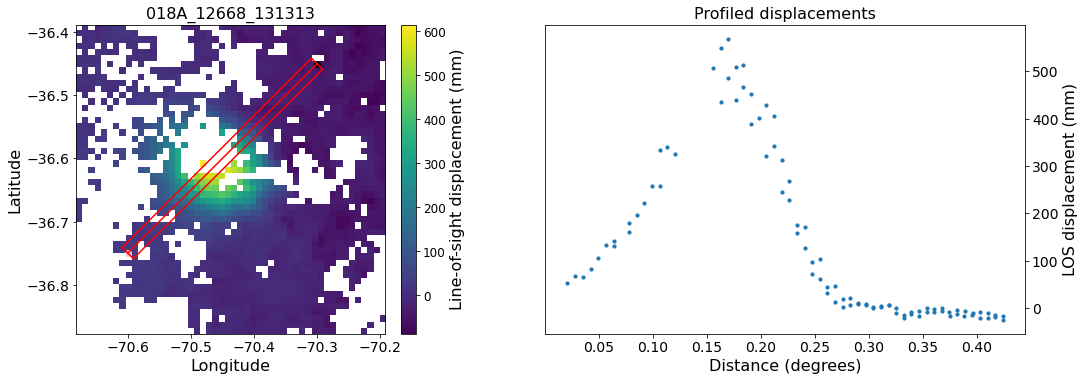

In [110]:
# start and end coordinates of the profile, and extra parameters
#####################################
prof_start = (-70.6, -36.75)
prof_end = (-70.3, -36.45)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.025 # total width of the profile in degrees (1 degree ~ 110 km)
}
#####################################

# run the profiler, the outputs are as follows:
# - bin_val = mean value of each bin
# - prof_bin_mids = distance along the profile to the middle of each bin
# - points_val = every velocity within the profile
# - points_dist = distance along the profile to every point within the profile
# - points_poly = polygon that defines the profile
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon,lat,disp_asc,prof_start,prof_end,prof_params)

# plot the ascending displacements and the profiled data
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout(w_pad=2)

# ascending map
im = axs[0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max])
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], color='pink')
axs[0].scatter(prof_end[0],prof_end[1], color='black')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=16)
axs[0].set_title('018A_12668_131313', fontsize=16)
axs[0].set_xlabel('Longitude', fontsize=16)
axs[0].set_ylabel('Latitude', fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].set_xlim(np.amin(lon), np.amax(lon))
axs[0].set_ylim(np.amin(lat), np.amax(lat))

# velocities projected onto profile
axs[1].scatter(points_dist, points_val, s=10)
axs[1].set_title('Profiled displacements', fontsize=16)
axs[1].set_xlabel("Distance (degrees)", fontsize=16)
axs[1].set_ylabel("LOS displacement (mm)", fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

plt.show()

It would be useful if our data were in metres instead of degrees for modelling, so let's projected from lat-long to UTM.

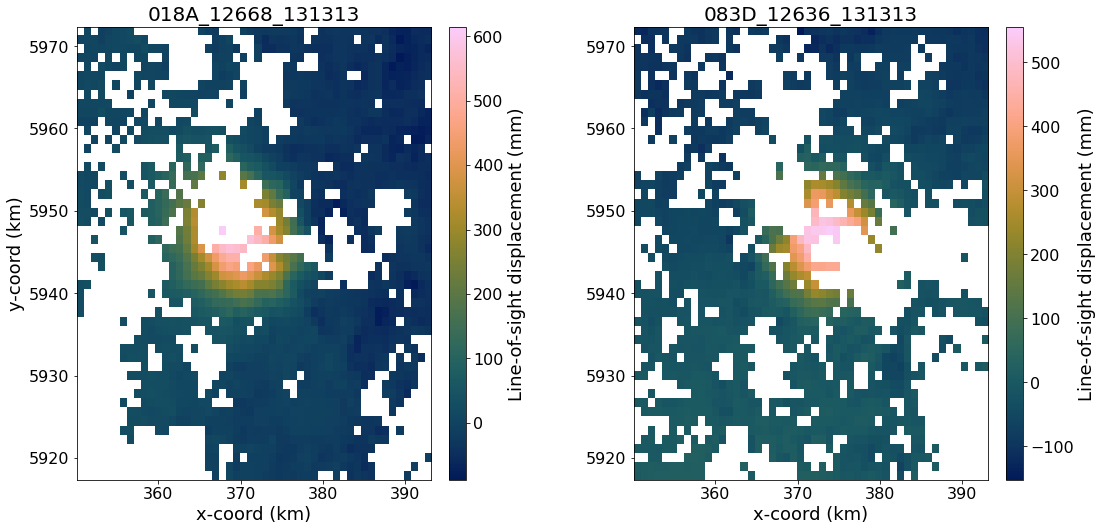

In [125]:
# get the utm zone projection
utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest = pyproj.aoi.AreaOfInterest(
        west_lon_degree  = np.amin(lon),
        south_lat_degree = np.amin(lat),
        east_lon_degree  = np.amax(lon),
        north_lat_degree = np.amax(lat),
    ),
)
utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)

# create transformer for LL to UTM
transformer = pyproj.Transformer.from_crs('epsg:4326', utm_crs)

# apply transform to our grids of lat long coordinates
x_utm, y_utm = transformer.transform(lat, lon)
x_utm, y_utm = x_utm/1000, y_utm/1000 # convert to km
xx_utm, yy_utm = np.meshgrid(x_utm, y_utm)
x_utm_min, x_utm_max, y_utm_min, y_utm_max = np.amin(x_utm), np.amax(x_utm), np.amin(y_utm), np.amax(y_utm)

# plot with new coords
fig, axs = plt.subplots(1,2,figsize=(15,7))
plt.tight_layout(w_pad=5)

# ascending displacements
im = axs[0].imshow(disp_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('018A_12668_131313', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)
axs[0].set_xlim(x_utm_min, x_utm_max)
axs[0].set_ylim(y_utm_min, y_utm_max)

# ascending displacements
im = axs[1].imshow(disp_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('083D_12636_131313', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].set_xlim(x_utm_min, x_utm_max)
axs[1].set_ylim(y_utm_min, y_utm_max)

plt.show()

We'll now run our forward model, projecting the modelled displacements into the line-of-sight for both frames. We'll plot the modelled displacements, the real displacements, and the residual between the two.

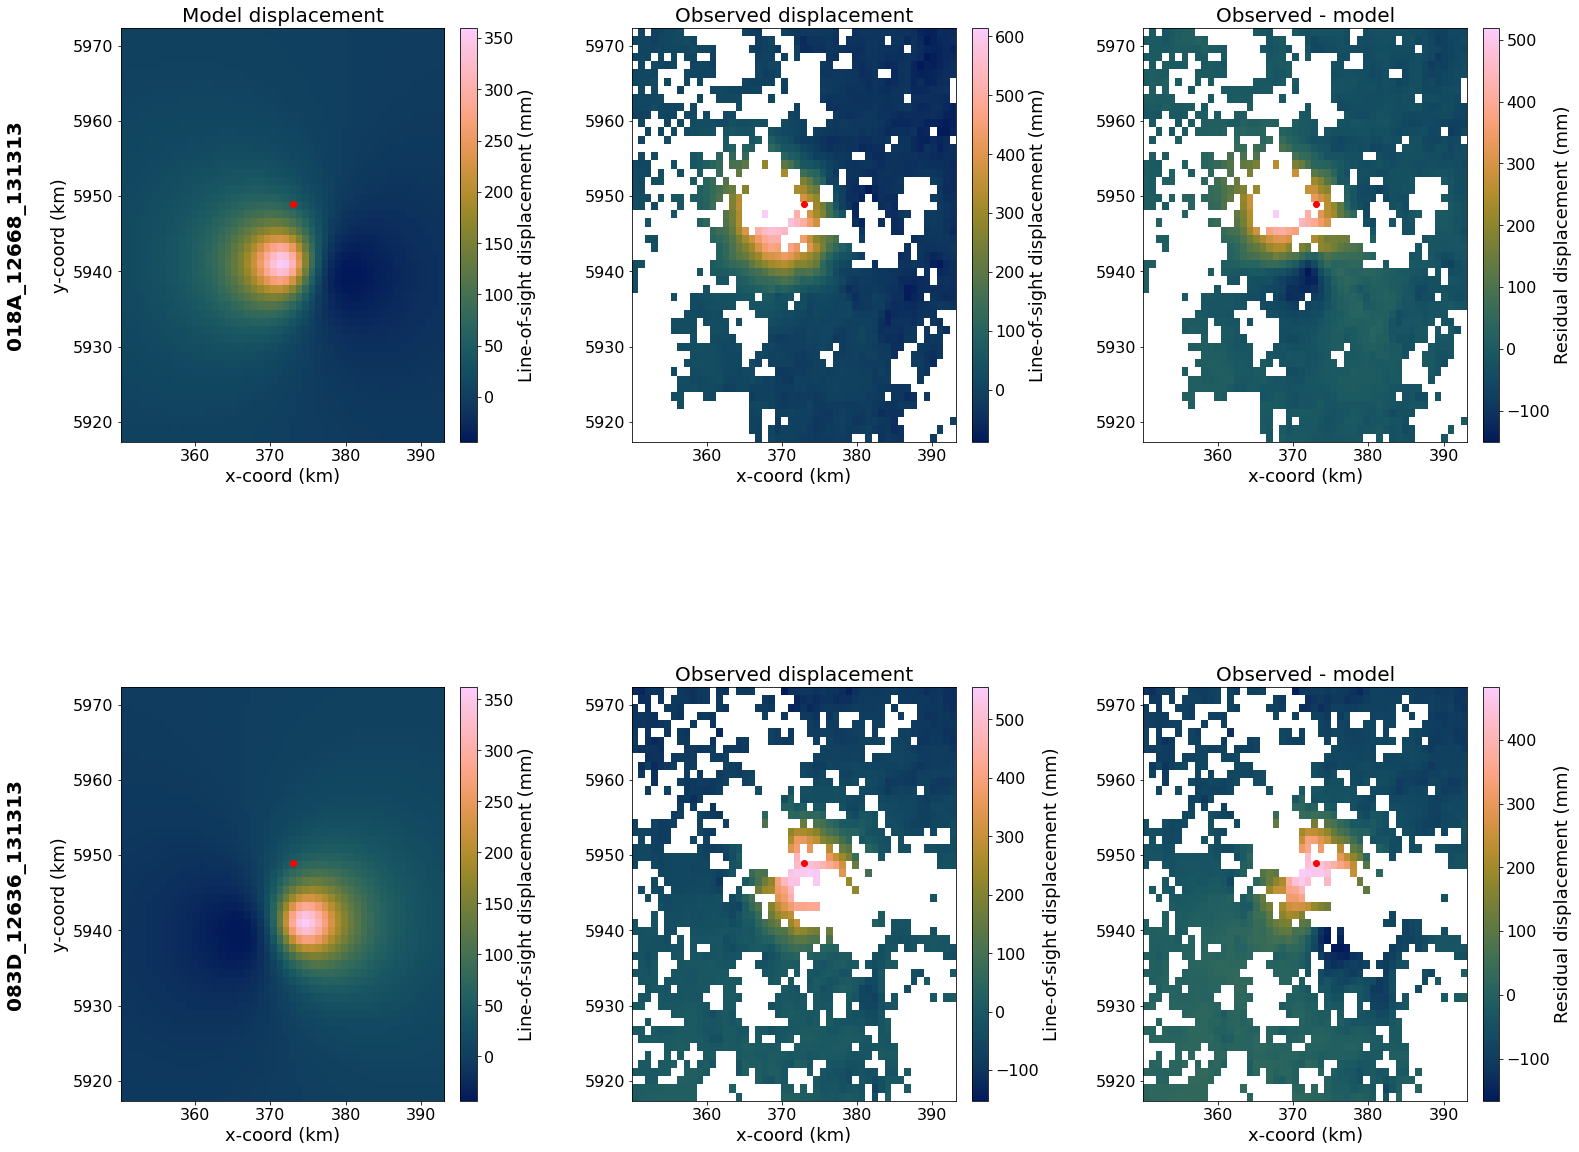

In [141]:
# setup model params
#####################################
source_depth = 5 # depth to point (km)
dV = 5e7 # change in volume (m^3)
nu = 0.25 # poisson's ratio for medium
xcen, ycen = 373, 5949
#####################################

# run model
ux, uy, uz = lib.mogi_source(xx_utm*1000, yy_utm*1000, xcen=xcen*1000, ycen=ycen*1000, d=source_depth*1000, dV=dV, nu=nu)
ux, uy, uz = ux*1000, uy*1000, uz*1000

# heading and incidence angles
heading_asc, heading_desc = -170, -10 # degrees
incidence = 51 # degrees

# create grids of these angles
heading_grid_asc = np.ones(xx_utm.shape) * heading_asc
heading_grid_desc = np.ones(xx_utm.shape) * heading_desc
incidence_grid = np.ones(xx_utm.shape) * incidence

# generate conversions for each components to LOS (asc)
x2los_asc = np.cos(np.deg2rad(heading_grid_asc)) * np.sin(np.deg2rad(incidence_grid))
y2los_asc = np.sin(np.deg2rad(heading_grid_asc)) * np.sin(np.deg2rad(incidence_grid))
z2los_asc = np.cos(np.deg2rad(incidence_grid))

# same for desc
x2los_desc = np.cos(np.deg2rad(heading_grid_desc)) * np.sin(np.deg2rad(incidence_grid))
y2los_desc = np.sin(np.deg2rad(heading_grid_desc)) * np.sin(np.deg2rad(incidence_grid))
z2los_desc = np.cos(np.deg2rad(incidence_grid))

# calculate total displacement in los 
ulos_asc = (ux * x2los_asc) + (uy * y2los_asc) + (uz * z2los_asc)
ulos_desc = (ux * x2los_desc) + (uy * y2los_desc) + (uz * z2los_desc)


# plot model, data, and residual
fig, axs = plt.subplots(2,3,figsize=(20,17))
fig.tight_layout(h_pad=10, w_pad = 10)

# ascending model
im = axs[0,0].imshow(ulos_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[0,0].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,0].set_title('Model displacement', fontsize=20)
axs[0,0].set_xlabel('x-coord (km)', fontsize=18)
axs[0,0].set_ylabel('y-coord (km)', fontsize=18)
axs[0,0].tick_params(labelsize=16)
axs[0,0].set_xlim(x_utm_min, x_utm_max)
axs[0,0].set_ylim(y_utm_min, y_utm_max)
axs[0,0].annotate('018A_12668_131313', xy=(0, 0.5), xytext=(-axs[0,0].yaxis.labelpad - 40, 0),
                xycoords=axs[0,0].yaxis.label, textcoords='offset points',
                fontsize=20, ha='left', va='center', rotation=90, weight='bold')

# ascending data
im = axs[0,1].imshow(disp_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[0,1].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,1].set_title('Observed displacement', fontsize=20)
axs[0,1].set_xlabel('x-coord (km)', fontsize=18)
axs[0,1].tick_params(labelsize=16)
axs[0,1].set_xlim(x_utm_min, x_utm_max)
axs[0,1].set_ylim(y_utm_min, y_utm_max)

# asceding residual
im = axs[0,2].imshow(disp_asc-ulos_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[0,2].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Residual displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,2].set_title('Observed - model', fontsize=20)
axs[0,2].set_xlabel('x-coord (km)', fontsize=18)
axs[0,2].tick_params(labelsize=16)
axs[0,2].set_xlim(x_utm_min, x_utm_max)
axs[0,2].set_ylim(y_utm_min, y_utm_max)


# descending model
im = axs[1,0].imshow(ulos_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[1,0].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,0].set_xlabel('x-coord (km)', fontsize=18)
axs[1,0].set_ylabel('y-coord (km)', fontsize=18)
axs[1,0].tick_params(labelsize=16)
axs[1,0].set_xlim(x_utm_min, x_utm_max)
axs[1,0].set_ylim(y_utm_min, y_utm_max)
axs[1,0].annotate('083D_12636_131313', xy=(0, 0.5), xytext=(-axs[1,0].yaxis.labelpad - 40, 0),
                xycoords=axs[1,0].yaxis.label, textcoords='offset points',
                fontsize=20, ha='left', va='center', rotation=90, weight='bold')

# descending data
im = axs[1,1].imshow(disp_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[1,1].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,1].set_title('Observed displacement', fontsize=20)
axs[1,1].set_xlabel('x-coord (km)', fontsize=18)
axs[1,1].tick_params(labelsize=16)
axs[1,1].set_xlim(x_utm_min, x_utm_max)
axs[1,1].set_ylim(y_utm_min, y_utm_max)

# descending residual
im = axs[1,2].imshow(disp_desc-ulos_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
axs[1,2].scatter(xcen, ycen, color='red')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Residual displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,2].set_title('Observed - model', fontsize=20)
axs[1,2].set_xlabel('x-coord (km)', fontsize=18)
axs[1,2].tick_params(labelsize=16)
axs[1,2].set_xlim(x_utm_min, x_utm_max)
axs[1,2].set_ylim(y_utm_min, y_utm_max)

plt.show()

## 5. Atmospheric corrections - GACOS

InSAR analysis of volcanoic sources tends to be strongly influenced by atmospherc noise, which partially correlates with topography.